In [321]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interp
from scipy.stats import norm
#1. IMPORTING PACKAGES AND LIBRARIES
%matplotlib inline
%load_ext autoreload
%autoreload 2
from contextlib import suppress
import os
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.img_tiles import OSM
from cartopy.io.img_tiles import GoogleTiles as moa
from cycler import cycler
import scipy
import seaborn as sns
import sys
import glob
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xarray as xr
import pyproj
import osr
import datetime
import subprocess
import shutil
import numpy as np
from ipywidgets import interact
import pandas as pd
import pickle
from scipy.signal import savgol_filter
import time
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
from sklearn import preprocessing
from sklearn import preprocessing


#own libary
import nsidc 

from functions_pmrs import loadCM
from functions_pmrs import applyshift
from functions_pmrs import calculateQR
from functions_pmrs import probability
from functions_pmrs import NQT
from functions_pmrs import calc_performance_scores_new


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [322]:
#SELECT BOUNDS AND START / END DATES
bounds = [( -19., 20.),
          (-11., 27.),
         ]
#Select set of POI's to use

# points = pd.read_csv('poizambeziplain.csv')   #Kalabo (weinig goede resultaten)
points = pd.read_csv('poi_senaga.csv')
# points = pd.read_csv('POIs_RE_3p.csv')


#adjust according to number of points in POI's
points_interest = [(points.xcoord[0],points.ycoord[0]),
                   (points.xcoord[1],points.ycoord[1])]
#                    (points.xcoord[2],points.ycoord[2]),
#                    (points.xcoord[3],points.ycoord[3]),
#                    (points.xcoord[4],points.ycoord[4])]
#                    (points.xcoord[5],points.ycoord[5])]
#                    (points.xcoord[6],points.ycoord[6]) 


# Download discharge data, no adjustment 
# dQ = pd.read_csv('ZAMBEZIDISCHARGE.csv',sep=';',parse_dates=['DATE'],index_col = ['DATE'],na_filter=True)
dQ = pd.read_csv('ZAMBEZIDISCHARGE.csv',sep=';',na_filter=True) #,parse_dates=['DATE'],index_col = ['DATE']
dQ['Date'] = pd.to_datetime(dQ['Date'])



#---------------------------#---------------------------#---------------------------#---------------------------#

# DOWNLOAD THE CORRECT DATA
# This cell calls the right download and "glues" the years together. 

fns=None

year = 2009  #change year to select specific year to see [2002-2011]

# 25 km resolution PMSR DATA
# fns = glob.glob(f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/25km36ghz/NSIDC_Test_{year}.nc')
#select this next one for full period data string (whole AMSR period)
fns = glob.glob('/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/25km36ghz/*.nc') # select this line to get the whole AMSR-E period

#select this next one for full period data string (whole DSMP period)
# fns = glob.glob('/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/25km36ghz/DMSP/*.nc') # select this line to get the whole AMSR-E period

# 3.125 km resolution PMSR DATA

# fns = glob.glob(f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/3km36ghz/NSIDC_Test_{year}.nc')
#select this next one for full period data string (whole AMSR period)
# fns = glob.glob('/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/3km36ghz/*.nc') # select this line to get the whole AMSR-E period

fns.sort()
ds = xr.open_mfdataset(fns)

#---------------------------#---------------------------#---------------------------#---------------------------#

# Discharge data location
# location = 'Kalabo'  
location = 'Senanga'
# location = 'Lukulu'


#---------------------------#---------------------------#---------------------------#---------------------------#


# TRANSFORMING, NO ADJUSTMENT NEEDED
proj4str = '+proj=cea +lat_0=0 +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m'
# we define a projection object for lat-lon WGS84 (EPSG code 4326)
proj_out = pyproj.Proj(init='epsg:4326')
# we define a projection object for the projection used in the downloaded grids.
proj_in = pyproj.Proj(proj4str)

# here we convert the coordinates in lat-lon into the coordinate system of the downloaded grids.
bounds_xy = nsidc.proj_coords(bounds, proj_out, proj_in)
points_xy = nsidc.proj_coords(points_interest, proj_out, proj_in)
points_x, points_y = zip(*points_xy)

#---------------------------#---------------------------#---------------------------#---------------------------#
sns.set()

<ipython-input-322-4b2263d88d4b>:53: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  ds = xr.open_mfdataset(fns)
/Users/oscarkeunen/opt/anaconda3/envs/afstuderen/lib/python3.8/site-packages/xarray/backends/api.py:926: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  combined = auto_combine(
/Users/oscarkeunen/opt/anaconda3/envs/afstuderen/lib/python3.8/site-packages/pyproj/crs.py:77: F

Text(0.5, 0, 'C/M ratio synthetic [-]')

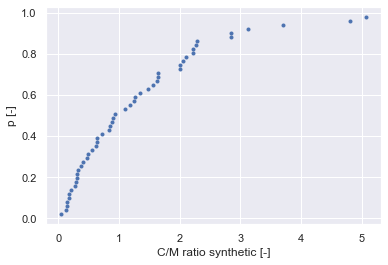

In [323]:
samples = np.random.gamma(1., scale=1.0, size=50)
# interp.interp1d()
# plt.plot(np.sort(samples), '.')
p = np.linspace(1./(1+len(samples)), 1-(1./(1+len(samples))), len(samples))
plt.plot(np.sort(samples), p, '.')
plt.ylabel('p [-]')
plt.xlabel('C/M ratio synthetic [-]')

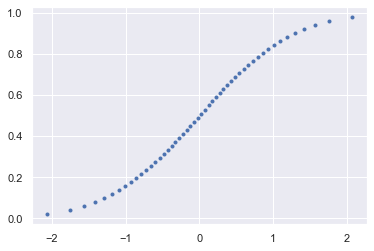

In [324]:
nqt = norm.ppf(p)
plt.plot(nqt, p, '.')

(array([2., 3., 5., 7., 8., 8., 7., 5., 3., 2.]),
 array([-2.0619165, -1.6495332, -1.2371499, -0.8247666, -0.4123833,
         0.       ,  0.4123833,  0.8247666,  1.2371499,  1.6495332,
         2.0619165]),
 <a list of 10 Patch objects>)

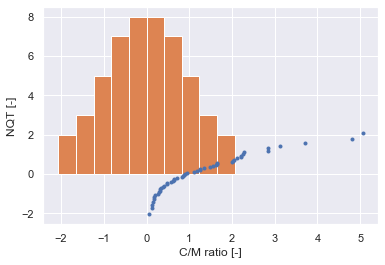

In [564]:
plt.plot(np.sort(samples), nqt, '.')
plt.xlabel('C/M ratio [-]')
plt.ylabel('NQT [-]')



Text(0, 0.5, 'NQT [-]')

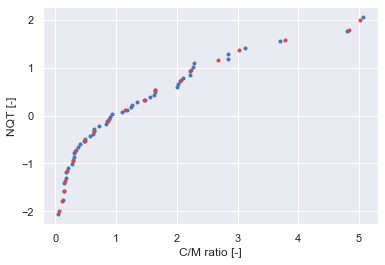

In [326]:
mapping_nqt_to_cm = interp.interp1d(nqt, np.sort(samples))
new_nqt_values = np.linspace(-2., 2., 20)
cm_mapped = mapping_nqt_to_cm(new_nqt_values)
plt.plot(np.sort(samples), nqt, '.')
plt.plot(cm_mapped, new_nqt_values, 'r.')
plt.xlabel('C/M ratio [-]')
plt.ylabel('NQT [-]')


In [580]:
shift= 15
rollingvalue = 6
selection= 12 # < number of months to be choosen
plot = 0


In [595]:
df = loadCM(points_xy,ds, rollingvalue)
df = applyshift(df,rollingvalue,shift,plot)
df.POI1.fillna(1, inplace=True)
df.POI4.fillna(1, inplace=True)

/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


Text(0.5, 0, 'C/M ratio synthetic [-]')

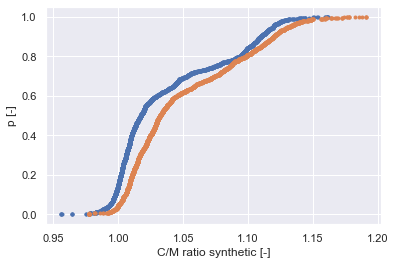

In [582]:
samples_Senanga_POI4 = df.POI4
samples_Senanga_POI1 = df.POI1


p = np.linspace(1./(1+len(df.POI4)), 1-(1./(1+len(df.POI4))), len(df.POI4))

plt.plot(np.sort(samples_Senanga_POI4), p, '.')
plt.ylabel('p [-]')
plt.xlabel('C/M ratio synthetic [-]')

plt.plot(np.sort(samples_Senanga_POI1), p, '.')
plt.ylabel('p [-]')
plt.xlabel('C/M ratio synthetic [-]')

# plt.plot(np.sort(samples_Senanga_POI4), np.sort(samples_Senanga_POI1), '.')
# plt.ylabel('C/M ratio synthetic [-]')
# plt.xlabel('C/M ratio synthetic [-]')



(array([10.,  3.,  3.,  5.,  7., 14., 25., 15.,  9.,  9.]),
 array([-2.57473216, -2.09533961, -1.61594707, -1.13655452, -0.65716197,
        -0.17776943,  0.30162312,  0.78101567,  1.26040821,  1.73980076,
         2.21919331]),
 <a list of 10 Patch objects>)

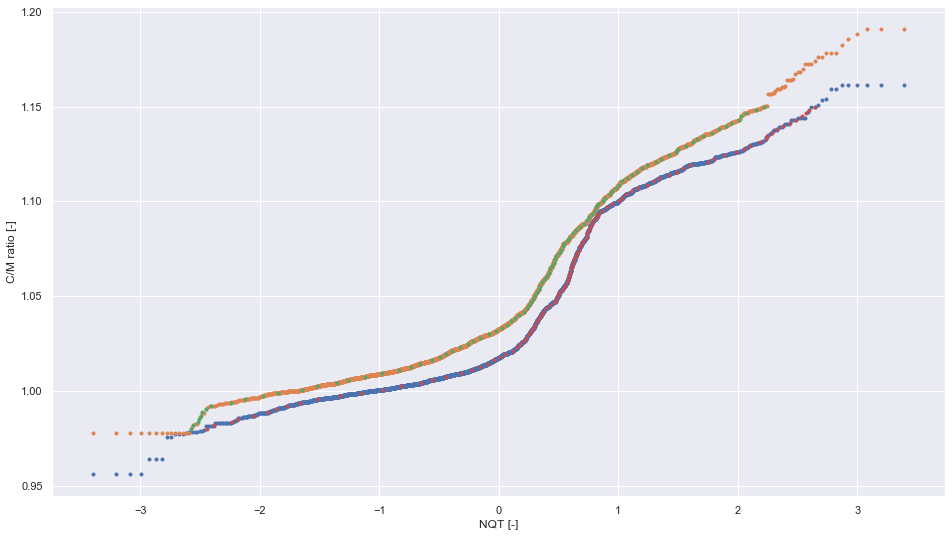

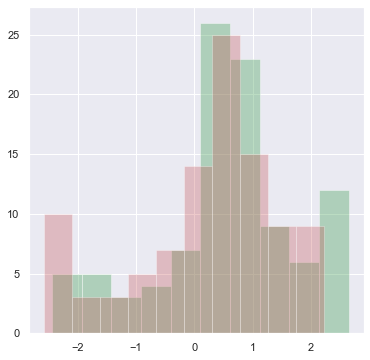

In [594]:
nqt_Senanga = norm.ppf(p)
# # df_norm = preprocessing.normalize(df,norm='max',axis=0,copy=True)
# df_norm = df -np.mean(df)


# nqt_POI4 = norm.ppf((df_norm.POI4), loc =0 , scale=1)
# # nqt_POI1 = norm.ppf((df_norm[:,1]), loc =0 , scale=1)


# plt.figure(figsize=(18,6))
# plt.subplot(1,2,1)
# plt.plot(samples_Senanga_POI1,samples_Senanga_POI4,'.')

# plt.subplot(1,2,2)
# plt.plot(nqt_Senanga,np.sort(samples_Senanga_POI1),'g.',alpha =0.5)
# plt.plot(nqt_Senanga,np.sort(samples_Senanga_POI4),'r.',alpha =0.5)



# df_nqt =pd.DataFrame({'NQT': nqt_Senanga, 'POI1': nqt_POI1, 'POI4': nqt_POI4},index =df.index) 


#---- NQT TO CM

mapping_nqt_to_cm_POI4 = interp.interp1d(nqt_Senanga, np.sort(samples_Senanga_POI4))
mapping_nqt_to_cm_POI1 = interp.interp1d(nqt_Senanga, np.sort(samples_Senanga_POI1))


# new_nqt_values= np.linspace(-3, 3, 50)

# cm_mapped_POI4 = mapping_nqt_to_cm_POI4(new_nqt_values)
# cm_mapped_POI1 = mapping_nqt_to_cm_POI1(new_nqt_values)

# plt.figure(figsize=(16,9))
# plt.plot(np.sort(samples_Senanga_POI4),nqt_Senanga , '.')  
# plt.plot(cm_mapped_POI4, new_nqt_values, 'r.')
# plt.plot(np.sort(samples_Senanga_POI1),nqt_Senanga , '.')  
# plt.plot(cm_mapped_POI1, new_nqt_values, 'g.')
# plt.ylabel('NQT [-]')
# plt.xlabel('C/M ratio [-]')

#--- CM TO NQT
mapping_cm_to_nqt_POI4 = interp.interp1d(np.sort(samples_Senanga_POI4), nqt_Senanga)#,fill_value="extrapolate")
mapping_cm_to_nqt_POI1 = interp.interp1d(np.sort(samples_Senanga_POI1), nqt_Senanga)#,fill_value="extrapolate")


new_cm_values=  np.linspace(0.98, 1.15, 100)

nqt_mapped_POI4 = mapping_cm_to_nqt_POI4(new_cm_values)
nqt_mapped_POI1 = mapping_cm_to_nqt_POI1(new_cm_values)


plt.figure(figsize=(16,9))
plt.plot(nqt_Senanga, np.sort(samples_Senanga_POI4), '.')  
plt.plot(nqt_mapped_POI4, new_cm_values, 'r.') 
plt.plot(nqt_Senanga, np.sort(samples_Senanga_POI1), '.')  
plt.plot(nqt_mapped_POI1, new_cm_values, 'g.') 
plt.xlabel('NQT [-]')
plt.ylabel('C/M ratio [-]')

plt.figure(figsize=(6,6))
plt.hist(nqt_mapped_POI4,color='g',alpha=0.4)
plt.hist(nqt_mapped_POI1,color='r',alpha=0.3)





In [370]:

mapping_nqt_to_cm = interp.interp1d(nqt_POI4, np.sort(samples_Senanga_POI4))

# cm_mapped = mapping_nqt_to_cm(new_nqt_values) 
# plt.plot(np.sort(samples_Senanga_POI4), nqt_Senanga, '.')
# plt.plot(cm_mapped, samples_Senanga_POI1, 'r.')
# # plt.xlabel('C/M ratio [-]')
# # plt.ylabel('NQT [-]')

# # np.quantile(nqt_POI1, .75)
# # df_nqt['quantile_POI4'] = pd.qcut(df_nqt.POI4, 4, labels=False)
# # df_nqt['quantile_POI1'] = pd.qcut(df_nqt.POI1, 4, labels=False)
# # df_nqt.head(25)
df_nqt

ValueError: A value in x_new is above the interpolation range.

### 

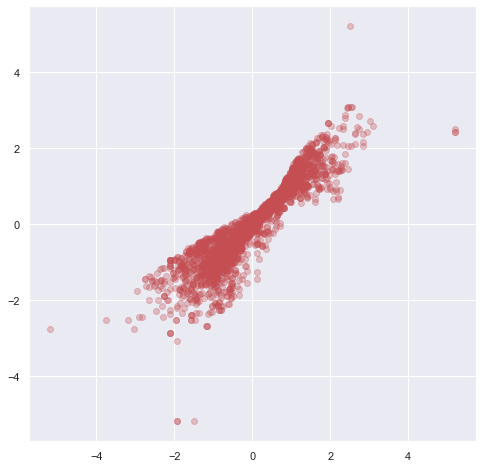

In [596]:


df_temp = np.sort(df,axis=1)
# df_norm = preprocessing.normalize(np.sort(df),norm='max',axis=0,copy=False)


quantile_transformer = preprocessing.QuantileTransformer(output_distribution='normal',copy=True)


X_trans = quantile_transformer.fit_transform(df_temp)
# X_trans = quantile_transformer.inverse_transform(X_trans)
 

plt.figure(figsize=(8,8))

plt.scatter(X_trans[:, 1],X_trans[:, 0],color='r',alpha=0.3)
df_nqt =pd.DataFrame({'POI1': X_trans[:, 0], 'POI4': X_trans[:, 1]},index =df.index) 




# #### Histogram of distribution
# f, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4,figsize=(12,4))


# ax0.hist(df.POI1, bins=100)
# ax0.set_ylabel('Probability')
# ax0.set_xlabel('Target')
# ax0.set_title('Target distribution')

# ax1.hist(X_trans[:,0], bins=100)
# ax1.set_ylabel('Probability')
# ax1.set_xlabel('Target')
# ax1.set_title('Transformed target distribution')

# ax2.hist(df.POI4, bins=100)
# ax2.set_ylabel('Probability')
# ax2.set_xlabel('Target')
# ax2.set_title('Target distribution')

# ax3.hist(X_trans[:,1], bins=100)
# ax3.set_ylabel('Probability')
# ax3.set_xlabel('Target')
# ax3.set_title('Transformed target distribution')

# # f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

Text(0, 0.5, 'NQT [-]')

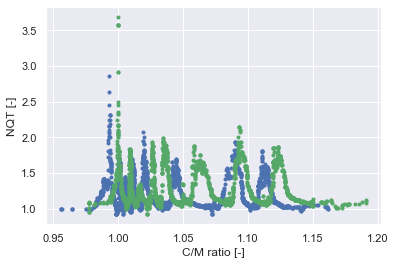

In [166]:
plt.plot(np.sort(samples_Senanga_POI4),nqt_POI4, 'b.')
plt.plot(np.sort(samples_Senanga_POI1), nqt_POI1, 'g.')

plt.xlabel('C/M ratio [-]')
plt.ylabel('NQT [-]')


ValueError: x and y must have same first dimension, but have shapes (2922,) and (50,)

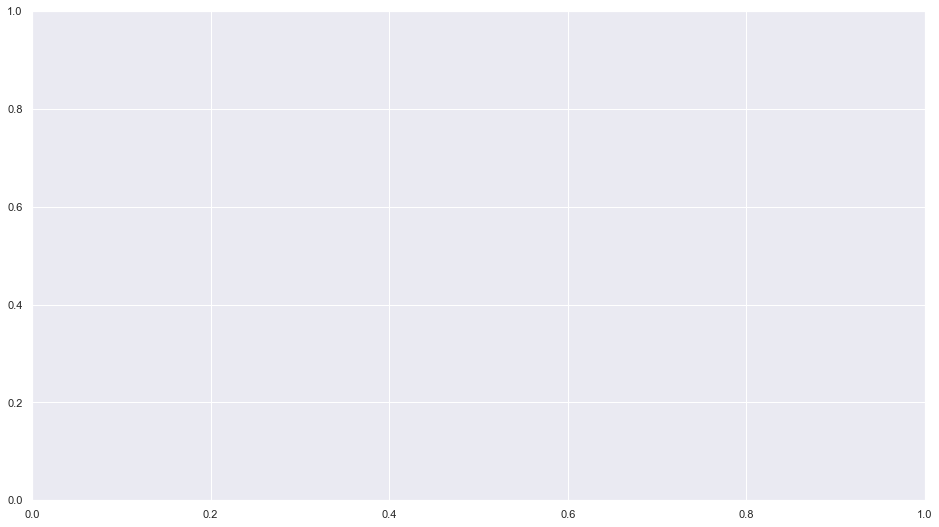

In [243]:
mapping_nqt_to_cm = interp.interp1d(nqt_Senanga, np.sort(samples_Senanga_POI1),bounds_error=True)
new_nqt_values= np.linspace(1, 1.05, 4)



plt.figure(figsize=(16,9))
cm_mapped = mapping_nqt_to_cm(new_nqt_values)
plt.plot(np.sort(samples_Senanga_POI1), nqt, '.')
plt.plot(cm_mapped, new_nqt_values, 'r.')
plt.xlabel('C/M ratio [-]')
plt.ylabel('NQT [-]')


In [244]:
mapping_cm_to_nqt_POI4 = interp.interp1d(np.sort(samples_Senanga_POI4),nqt_Senanga)#,bounds_error=False,fill_value="extrapolate")
mapping_cm_to_nqt_POI1 = interp.interp1d(np.sort(samples_Senanga_POI1),nqt_Senanga)#,bounds_error=False,fill_value="extrapolate")

new_cm_values= np.linspace(1, 1.15, 500)
cm = 1.05


plt.figure(figsize=(16,9))
nqt_mappedPOI4 = mapping_cm_to_nqt_POI4(new_cm_values)
nqt_mappedPOI1 = mapping_cm_to_nqt_POI1(new_cm_values)

# plt.plot( nqt,np.sort(samples_Senanga_POI4) , '.')
# plt.plot(nqt_mapped, new_cm_values, 'r.')
plt.scatter(nqt_mapped_POI4, nqt_mapped_POI1)
plt.xlabel('NQT [-]')
# plt.ylabel('C/M ratio [-]')




NameError: name 'nqt_mapped_POI4' is not defined

<Figure size 1152x648 with 0 Axes>

Text(0, 0.5, 'C/M ratio [-]')

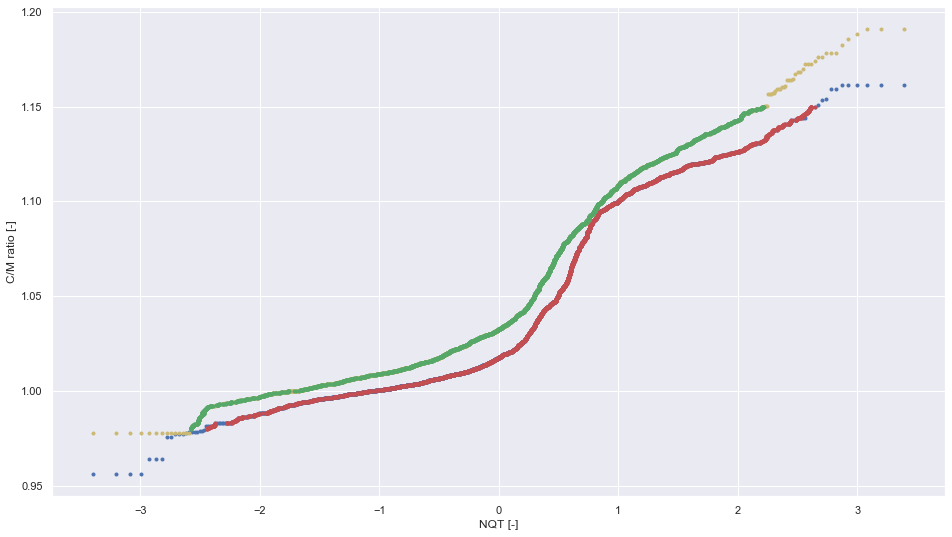

In [250]:
mapping_cm_to_nqt_POI4 = interp.interp1d(np.sort(samples_Senanga_POI4),nqt_Senanga)#,bounds_error=False,fill_value="extrapolate")
mapping_cm_to_nqt_POI1 = interp.interp1d(np.sort(samples_Senanga_POI1),nqt_Senanga)#,bounds_error=False,fill_value="extrapolate")

new_cm_values= np.linspace(0.98, 1.15, 2922)
cm = 1.05


plt.figure(figsize=(16,9))
nqt_mapped_POI4 = mapping_cm_to_nqt_POI4(new_cm_values)
nqt_mapped_POI1 = mapping_cm_to_nqt_POI1(new_cm_values)



plt.plot( nqt_Senanga,np.sort(samples_Senanga_POI4) , '.')
plt.plot(nqt_mapped_POI4, new_cm_values, 'r.')
plt.plot( nqt_Senanga,np.sort(samples_Senanga_POI1) , 'y.')
plt.plot(nqt_mapped_POI1, new_cm_values, 'g.')
plt.xlabel('NQT [-]')
plt.ylabel('C/M ratio [-]')

# plt.scatter(np.sort(samples_Senanga_POI1),np.sort(samples_Senanga_POI4))
# plt.scatter(nqt_mapped_POI1,nqt_mapped_POI4)





In [296]:
np.shape(nqt_POI4)

(2922,)

In [320]:
df_nqt =pd.DataFrame({'POI4': nqt_POI4, 'POI1': nqt_POI1},index =df.index) 


In [321]:
# df.POI1.fillna(1, inplace=True)
# df.POI4.fillna(1, inplace=True)
df_nqt

,POI4,POI1
2003-01-01,0.993726,1.084604
2003-01-02,0.993726,1.084604
2003-01-03,0.993726,1.084604
2003-01-04,0.993726,1.084604
2003-01-05,0.993726,1.084604
...,...,...
2010-12-27,1.020147,1.066788
2010-12-28,1.015450,1.088024
2010-12-29,1.002041,1.109762
2010-12-30,0.999771,1.122744


In [372]:
df=df_nqt
df

,POI1,POI4
2003-01-01,-2.101299,-2.106032
2003-01-02,-2.101299,-2.106032
2003-01-03,-2.101299,-2.106032
2003-01-04,-2.101299,-2.106032
2003-01-05,-2.101299,-2.106032
...,...,...
2010-12-27,-2.103182,-2.102978
2010-12-28,-2.100943,-2.103514
2010-12-29,-2.098714,-2.105060
2010-12-30,-2.097413,-2.105325


In [373]:
plot=1
selection =5

In [374]:
x_set = df['POI1']

df= df[df.index.month<selection] # select only the months in the rainy season to look at the effects of the CM ratio for inundation. 

model = smf.quantreg('POI4 ~ POI1', df) # call the model
quantiles = [0.10, 0.25, 0.75 , 0.90, 0.50]
fits = [model.fit(q=q) for q in quantiles]

x = df['POI1']
y = df['POI4']

fit = np.polyfit(x, y, deg=1)
_x = np.linspace(x.min(), x.max(), num=len(y))

res = model.fit(q=0.5)
    
    # fit lines
    
_y_010 = fits[0].params['POI1'] * _x + fits[0].params['Intercept']
_y_090 = fits[3].params['POI1'] * _x + fits[3].params['Intercept']
_y_025 = fits[1].params['POI1'] * _x + fits[1].params['Intercept']
_y_075 = fits[2].params['POI1'] * _x + fits[2].params['Intercept']
_y_050 = fits[4].params['POI1'] * _x + fits[4].params['Intercept']


# start and end coordinates of fit lines
p = np.column_stack((x, y))
a = np.array([_x[0], _y_010[0]]) #first point of 0.05 quantile fit line
b = np.array([_x[-1], _y_010[-1]]) #last point of 0.05 quantile fit line

a_ = np.array([_x[0], _y_090[0]])
b_ = np.array([_x[-1], _y_090[-1]])

a__ = np.array([_x[0], _y_025[0]]) #first point of 0.10 quantile fit line
b__ = np.array([_x[-1], _y_025[-1]]) #last point of 0.10 quantile fit line

a___ = np.array([_x[0], _y_075[0]])
b___ = np.array([_x[-1], _y_075[-1]])

#mask based on if coordinates are above 0.95 or below 0.05 quantile fitlines using cross product

mask = lambda p, a, b, a_, b_: (np.cross(p-a, b-a) > 0) | (np.cross(p-a_, b_-a_) < 0)
mask = mask(p, a, b, a_, b_)

if plot ==1:
    print(res.summary())

    figure, axes = plt.subplots(figsize=(10,10))
    axes.scatter(x[mask], df['POI4'][mask], facecolor='r', edgecolor='none', alpha=0.6, label='data point outside outer quantiles')
    axes.scatter(x[~mask], df['POI4'][~mask], facecolor='g', edgecolor='none', alpha=0.6, label='data point inside outer quantiles')

    axes.plot(x, fit[0] * x + fit[1], label='best-fit', c='grey')
    axes.plot(_x, _y_090, label=quantiles[0], c='red')
    axes.plot(_x, _y_010, label=quantiles[3], c='red')
    axes.plot(_x, _y_075, label=quantiles[1], c='orange')
    axes.plot(_x, _y_025, label=quantiles[2], c='orange')

    axes.set_title(f'Quantile Regression function {location} given LT = {shift}')
    axes.legend(fancybox=True, framealpha=0.5)
    axes.set_xlabel('POI1 - CM RATIO')
    axes.set_ylabel('POI4 - CM RATIO')
    axes.text(0.97,0.97, f'R-squared = %0.3f' %res.prsquared,fontsize =14)
    axes.grid(b='bool')

                         QuantReg Regression Results                          
Dep. Variable:                   POI4   Pseudo R-squared:               0.6326
Model:                       QuantReg   Bandwidth:                    0.003568
Method:                 Least Squares   Sparsity:                      0.01676
Date:                Tue, 07 Apr 2020   No. Observations:                  962
Time:                        11:33:40   Df Residuals:                      960
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1183      0.030     -3.953      0.000      -0.177      -0.060
POI1           0.9439      0.014     65.551      0.000       0.916       0.972


In [163]:
import numbers

import numpy as np
import matplotlib.pyplot as plt


def qqplot(x, y, quantiles=None, interpolation='nearest', ax=None, rug=False,
           rug_length=0.05, rug_kwargs=None, **kwargs):
    """Draw a quantile-quantile plot for `x` versus `y`.

    Parameters
    ----------
    x, y : array-like
        One-dimensional numeric arrays.

    ax : matplotlib.axes.Axes, optional
        Axes on which to plot. If not provided, the current axes will be used.

    quantiles : int or array-like, optional
        Quantiles to include in the plot. This can be an array of quantiles, in
        which case only the specified quantiles of `x` and `y` will be plotted.
        If this is an int `n`, then the quantiles will be `n` evenly spaced
        points between 0 and 1. If this is None, then `min(len(x), len(y))`
        evenly spaced quantiles between 0 and 1 will be computed.

    interpolation : {‘linear’, ‘lower’, ‘higher’, ‘midpoint’, ‘nearest’}
        Specify the interpolation method used to find quantiles when `quantiles`
        is an int or None. See the documentation for numpy.quantile().

    rug : bool, optional
        If True, draw a rug plot representing both samples on the horizontal and
        vertical axes. If False, no rug plot is drawn.

    rug_length : float in [0, 1], optional
        Specifies the length of the rug plot lines as a fraction of the total
        vertical or horizontal length.

    rug_kwargs : dict of keyword arguments
        Keyword arguments to pass to matplotlib.axes.Axes.axvline() and
        matplotlib.axes.Axes.axhline() when drawing rug plots.

    kwargs : dict of keyword arguments
        Keyword arguments to pass to matplotlib.axes.Axes.scatter() when drawing
        the q-q plot.
    """
    # Get current axes if none are provided
    if ax is None:
        ax = plt.gca()

    if quantiles is None:
        quantiles = min(len(x), len(y))

    # Compute quantiles of the two samples
    if isinstance(quantiles, numbers.Integral):
        quantiles = np.linspace(start=0, stop=1, num=int(quantiles))
    else:
        quantiles = np.atleast_1d(np.sort(quantiles))
    x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
    y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)

    # Draw the rug plots if requested
    if rug:
    
        # Default rug plot settings
        rug_x_params = dict(ymin=0, ymax=rug_length, c='gray', alpha=0.5)
        rug_y_params = dict(xmin=0, xmax=rug_length, c='gray', alpha=0.5)

        # Override default setting by any user-specified settings
        if rug_kwargs is not None:
            rug_x_params.update(rug_kwargs)
            rug_y_params.update(rug_kwargs)

        # Draw the rug plots
        for point in x:
            ax.axvline(point, **rug_x_params)
        for point in y:
            ax.axhline(point, **rug_y_params)

    # Draw the q-q plot
    ax.scatter(x_quantiles, y_quantiles, **kwargs)

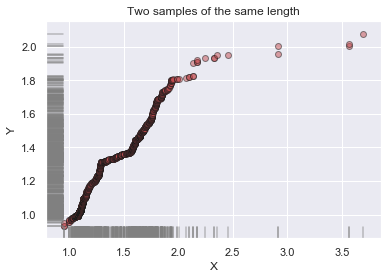

In [164]:
# Setup
rng = np.random.RandomState(0)  # Seed RNG for replicability

# Example 1: samples of the same length
n = 100  # Number of samples to draw
x = np.sort(df.POI1)  # Sample 1: X ~ N(0, 1)
y = np.sort(df.POI4)  # Sample 2: Y ~ t(5)

# Draw quantile-quantile plot
plt.figure()
qqplot(x, y, c='r', alpha=0.5, edgecolor='k',rug=True)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Two samples of the same length')
plt.show()
plt.close()
